# Part 1: writing an xspec script

In [1]:
#Import some things
import numpy as np
import scipy as sci
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

################## SPLITTING THE DATA ##################
#Channels represent bins in the energy spectrum. There are four spectra (A1, A2,
#B1, and B2), and I'll split each of them into train, cv, and test sets

#Specifying the channel range of each spectrum
channels_A1 = range(36,704+1)
channels_A2 = range(35,572+1)
channels_B1 = range(36,706+1)
channels_B2 = range(34,571+1)

#Splitting the data
A1_train, A1_split = train_test_split(channels_A1,test_size=0.4)
A1_cv, A1_test = train_test_split(A1_split,test_size=0.5)

A2_train, A2_split = train_test_split(channels_A2,test_size=0.4)
A2_cv, A2_test = train_test_split(A2_split,test_size=0.5)

B1_train, B1_split = train_test_split(channels_B1,test_size=0.4)
B1_cv, B1_test = train_test_split(B1_split,test_size=0.5)

B2_train, B2_split = train_test_split(channels_B2,test_size=0.4)
B2_cv, B2_test = train_test_split(B2_split,test_size=0.5)


#Creating strings for the "ignore" command,
#Which tells xspec what channels to ignore when fitting the spectrum.
#This is how I'll split the data in practice
def ignore(channels,spec_number):
    ignore_string = "ignore {}:".format(spec_number)
    for channel in channels:
        ignore_string += "{}, ".format(channel)
    ignore_string += "\n"
    return ignore_string

def notice(channels,spec_number):
    notice_string = "notice {}:".format(spec_number)
    for channel in channels:
        notice_string += "{}, ".format(channel)
    notice_string += "\n"
    return notice_string

split_train = ""
split_cv = ""
split_test = ""

#For training, tell xspec to ignore the cv
#and test sets
split_train += notice(A1_train,1)
split_train += notice(A2_train,2)
split_train += notice(B1_train,3)
split_train += notice(B2_train,4)

#For the cross validation, ignore the training
#and test sets
split_cv += notice(A1_cv,1)
split_cv += notice(A2_cv,2)
split_cv += notice(B1_cv,3)
split_cv += notice(B2_cv,4)

#For the final test, ignore the training
#and cv sets
split_test += notice(A1_test,1)
split_test += notice(A2_test,2)
split_test += notice(B1_test,3)
split_test += notice(B2_test,4)

In [4]:
######## MAKE XSPEC SCRIPTS TO FIT TO APECS, GET RMS ERROR ######
#os.chdir("/Users/samanthacreech/Documents/SCHOOL/First_year/Spring/Astro_research/Final_project/Part2")
fit_apecs = open("CV_FitApecs.xcm","w")

#APECS are thermal emission models, each of which represent a single gas temperature.
#We're trying to fit a multi-temperature model, but we aren't sure how many temperatures
#We should add before we start overfitting the data.
#So, let's cross validate!

#First, a command so thatxspec doesn't keep prompting the user when number of
#trials are exceeded
fit_apecs.write("query y\n")

#Modify a bunch of plot setttings
fit_apecs.write("setpl e\n")
#fit_apecs.write("setpl com res y 3e-5 0.01\n")
fit_apecs.write("setpl com time off\n")
fit_apecs.write("setpl com lw 5\n")
fit_apecs.write("setpl com cs 1.23\n")
fit_apecs.write("setpl com la pos y 2.5\n")
fit_apecs.write("setpl com reb 10 50\n")
fit_apecs.write("setpl com la y counts/s/keV\n")
#fit_apecs.write("setpl com resacle y2 0.3 1.7\n")

#Next, loop through the different models we'll be fitting
for comp in ["1apec","1apecIC","1apecSimp","2apec","3apec","4apec","profile","profileIC"]:
    ############# TRAINING STAGE
    #First, run the script that'll load the data and model
    fit_apecs.write("cd ..\n")
    fit_apecs.write("@PersGlobal_{}.xcm\n".format(comp))
    fit_apecs.write("cd Astr6410_Final\n")
    #Next, split the data into the training set
    fit_apecs.write("ignore **:**\n")
    fit_apecs.write(split_train)
    #Fit the model
    fit_apecs.write("fit\n")
    
    #fit_apecs.write("setpl la top {} Training Phase\n".format(comp))
    #fit_apecs.write("pl ldata ratio\n")
    #fit_apecs.write("hardcopy {}_Train.ps color\n".format(comp))
        
    #Open a file to write results to
    
    #Save residuals to a text file
    #NOTE: This'll save ALL channels, not just the ones that are noticed.
    for spec in range(1,5):
        fit_apecs.write("tclout plot resid y {}\n".format(spec))
        fit_apecs.write("echo $xspec_tclout > train_errors{}_{}.txt\n".format(spec,comp))
    fit_apecs.write("\n")
    
    ################ CROSS VALIDATION STAGE STAGE
    fit_apecs.write("ignore **:**\n")
    fit_apecs.write(split_cv)
    for spec in range(1,5):
        fit_apecs.write("tclout plot resid y {}\n".format(spec))
        fit_apecs.write("echo $xspec_tclout > cv_errors{}_{}.txt\n".format(spec,comp))
    fit_apecs.write("\n")
    
    #fit_apecs.write("setpl la top {} CV Phase\n".format(comp))
    #fit_apecs.write("pl ldata ratio\n")
    #fit_apecs.write("hardcopy {}_CV.ps color\n".format(comp))

    
    ################ TEST STAGE
    fit_apecs.write("ignore **:**\n")
    fit_apecs.write(split_test)
    
    for spec in range(1,5):
        fit_apecs.write("tclout plot resid y {}\n".format(spec))
        fit_apecs.write("echo $xspec_tclout > test_errors{}_{}.txt\n".format(spec,comp))
    fit_apecs.write("\n")
    
    #fit_apecs.write("setpl la top {} Test Phase".format(comp))
    #fit_apecs.write("pl ldata ratio\n")
    #fit_apecs.write("hardcopy {}_Test.ps color".format(comp))
    
fit_apecs.close()

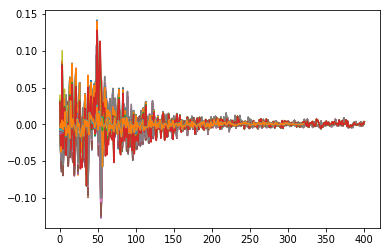

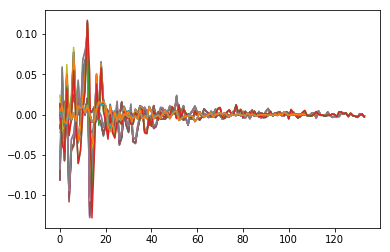

In [5]:
#Calculate total RMS
files = os.popen('ls').read().split()

#create arrays storing the filenames of the cross validation, training, and test
#data for each model
#This is is reading the residuals outputed by xspec (data-model)
cv_files = np.array(files)[[files[i].split("_")[0] == "cv" for i in range(0,len(files))]]
train_files = np.array(files)[[files[i].split("_")[0] == "train" for i in range(0,len(files))]]
test_files = np.array(files)[[files[i].split("_")[0] == "train" for i in range(0,len(files))]]

###Calculating the training error for each model 
train_errors = {}
for train in train_files:
    f = open(train)
    for line in f:
        components = train.split("_")[2].strip(".txt")#int(train.split("_")[2].strip("apec.txt"))-1
        
        data = line.split()
        data = np.array(data,dtype=float)
        plt.plot(range(0,len(data)),data)
        
        error = np.sqrt(np.sum(data**2)/len(data))
        train_errors[components] = error
    f.close()
plt.show()   

cv_errors = {}
for cv in cv_files:
    f = open(cv)
    for line in f:
        apec_numbers = cv.split("_")[2].strip(".txt")#int(cv.split("_")[2].strip("apec.txt"))-1
        data = line.split()
        data = np.array(data,dtype=float)
        plt.plot(range(0,len(data)),data)
        
        error = np.sqrt(np.sum(data**2)/len(data))
        cv_errors[apec_numbers] = error 
    f.close()
    
plt.show()

test_errors = {}
for test in test_files:
    apec_numbers = test.split("_")[2].strip(".txt")#int(test.split("_")[2].strip("apec.txt"))-1
    f = open(test)
    for line in f:
        data = line.split()
        data = np.array(data,dtype=float)
#        plt.plot(range(0,len(data)),data)
        
        error = np.sqrt(np.sum(data**2)/len(data))
        test_errors[apec_numbers] = error

#train_errors = np.array(train_errors)
#cv_errors = np.array(cv_errors)
#test_errors = np.array(test_errors)

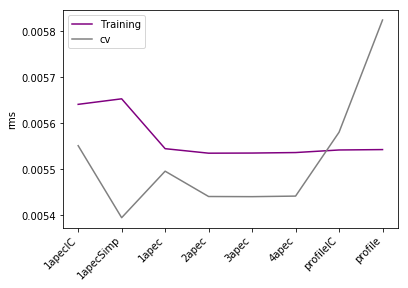

In [6]:
#Plotting the results

plt.plot(list(train_errors.keys()),np.array(list(train_errors.values())),label="Training",c="purple")
plt.plot(list(cv_errors.keys()),np.array(list(cv_errors.values())),label="cv",c="grey")


plt.ylabel("rms")
plt.xticks(rotation=45,ha="right")
#plt.show()
plt.legend()
plt.savefig("CV_errors.png",dpi=100,bbox_inches="tight")
plt.show()

In [7]:
print(test_errors["1apecSimp"])

0.005652872194421938
